In [193]:
import numpy as np
import torch
import sys
sys.path.append('./code')

from PIL import Image
from torchvision.models.vgg import vgg19
from utils import *

In [199]:
def imread(image, mode):
    return np.array(Image.open(image).convert(mode))
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
r1, eps1, r2, eps2 = 45, 0.01, 7, 1e-6
model = vgg19(pretrained=True)
vgg19_relus = [1, 3, 8]

path_to_images = ['images/IV_images/VIS1.png', 'images/IV_images/IR1.png']
imgs = [imread(p, mode='L') for p in path_to_images]

float_imgs = [(img / 255.).astype(np.float32) for img in imgs]
bases, details = decompose(float_imgs)

Wb_0 = sal_weights(imgs)
Wb_0 = np.moveaxis(Wb_0, -1, 0)  # easier indexed in for-loop
Wb = guided_optimize(float_imgs, Wb_0, r1, eps1)

fused_base = weighted_sum(bases, Wb)

tc_details = stack_to_tensor(details)
fused_detial = cnn_detail_fusion(tc_details, model, device, relus=vgg19_relus)

fused = np.clip(fused_base + fused_detial, 0, 1)
fused = np.rint(fused * 255).astype(np.uint8)


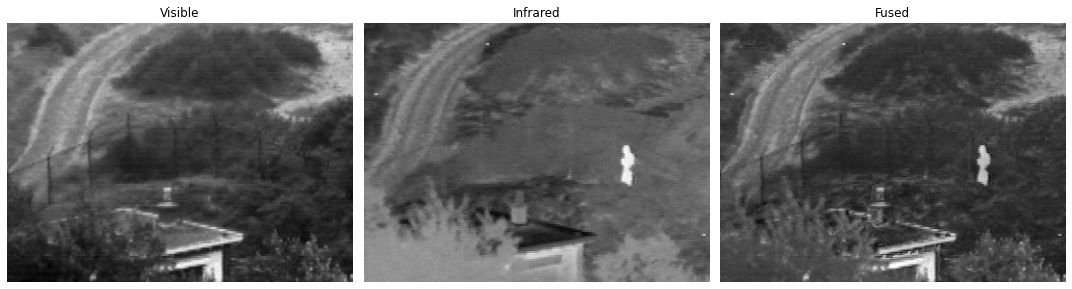

In [206]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(imgs[0], cmap='gray')
axes[0].set_title('Visible')
axes[1].imshow(imgs[1], cmap='gray')
axes[1].set_title('Infrared')
axes[2].imshow(fused, cmap='gray')
axes[2].set_title('Fused')
for ax in axes:
    ax.axis('off')
fig.tight_layout()

# Following results shown here can be produced with `/code/main.py`

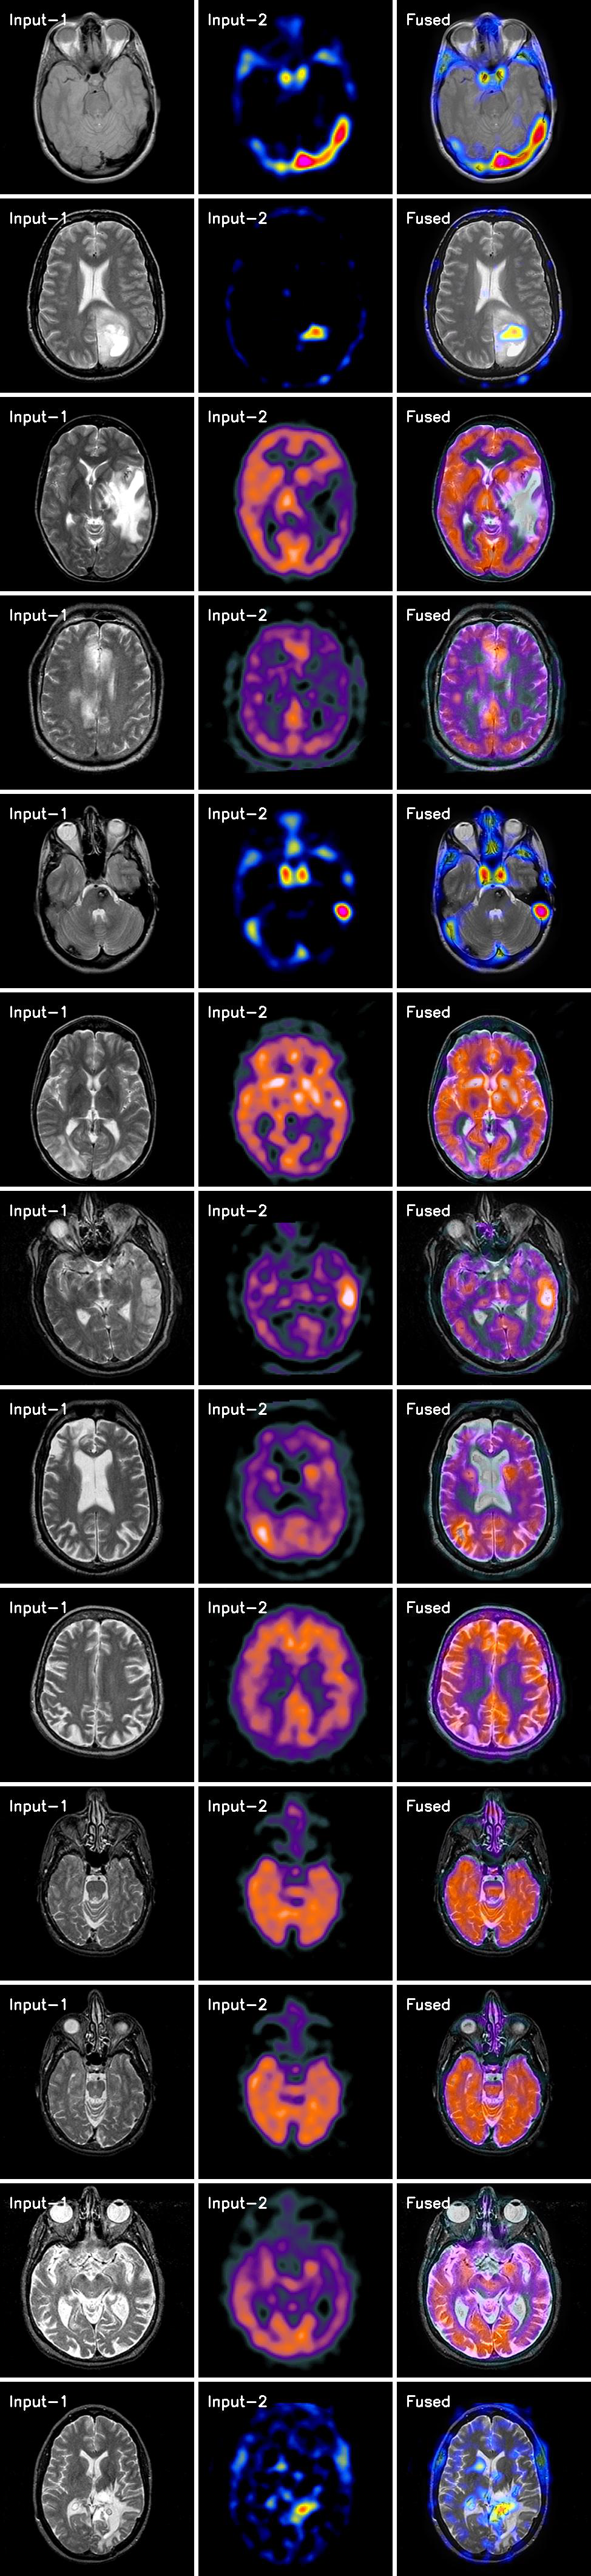

In [1]:
from wand.image import Image as WImage
img = WImage(filename='results/MRI-SPECT/combined.pdf')
img